# Nutrition

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

## Raw Data

In [2]:
DATA_PATH_AVG = './data/nutrients_avg.xlsx'
df = pd.read_excel(DATA_PATH_AVG)

FileNotFoundError: [Errno 2] No such file or directory: './data/nutrients_avg.xlsx'

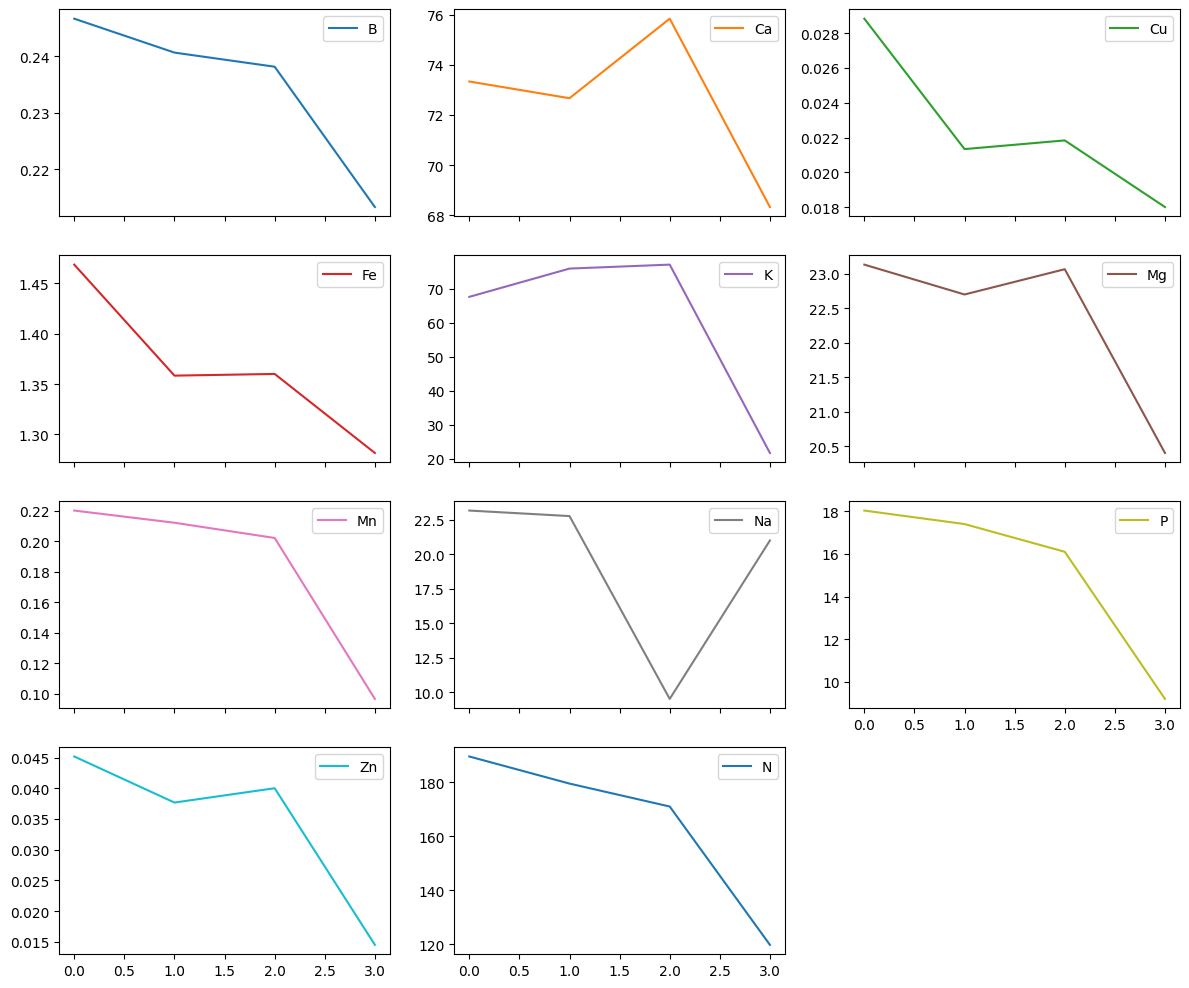

In [189]:
df_no_time = df.drop(columns='Time')
df_no_time.plot(subplots=True, layout=(4, 3), figsize=(12, 10), sharex=True)

# Adjust the layout to prevent overlap
plt.tight_layout()
plt.show()

## Data Preparation

In [190]:
from sklearn.preprocessing import MinMaxScaler

# Convert DataFrame to NumPy array
X = df_no_time.to_numpy()

# Sort data along axis=0 and reverse to get descending order
data = np.sort(X, axis=0)[::-1]


# If a scaler is applied it also has to be applied to the fertilizer

# scaler = MinMaxScaler()

# # Fit the scaler and transform the data to scale each column independently
# data = scaler.fit_transform(data)

# # Now each column of data is scaled to the range [0, 1]
# print(data)


In [191]:
from scipy.interpolate import interp1d

def interpolate_data(data, num_points=500, kind='cubic'):
    x_original = np.arange(data.shape[0])  # Original index positions
    x_interp = np.linspace(0, data.shape[0] - 1, num_points)  # Interpolation index positions
    # Initialize an array to store interpolated data
    Y_interp = np.zeros((num_points, data.shape[1]))
    # Interpolate each column
    for col in range(data.shape[1]):
        f = interp1d(x_original, data[:, col], kind='cubic')  # Use cubic interpolation for smoothness
        Y_interp[:, col] = f(x_interp)

    return x_interp, Y_interp

x_interp, Y_interp = interpolate_data(data, num_points=4, kind='linear')

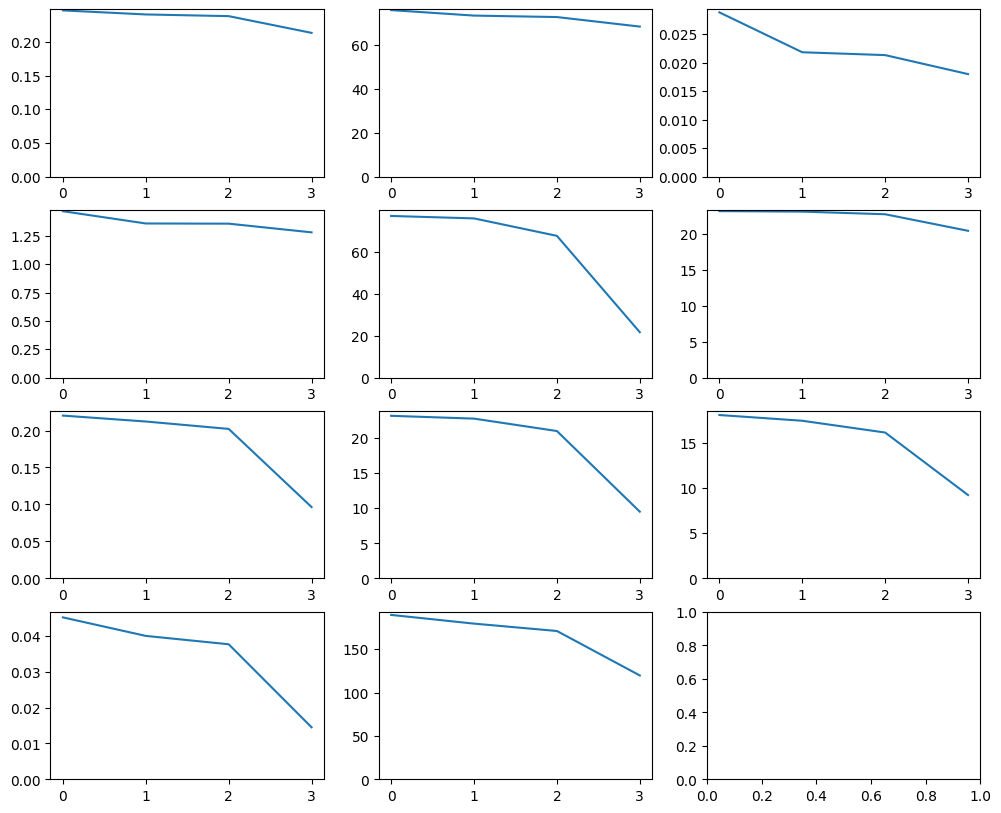

In [192]:
def plot_curves(x, y):
    # Plot the derivative of the first column
    fig, axes = plt.subplots(4,3, figsize=(12,10))
    axes = axes.flatten()
    for i in range(11):
        axes[i].plot(x,y[:, i])
        axes[i].set_ylim([0,None])

plot_curves(x=x_interp, y=Y_interp)

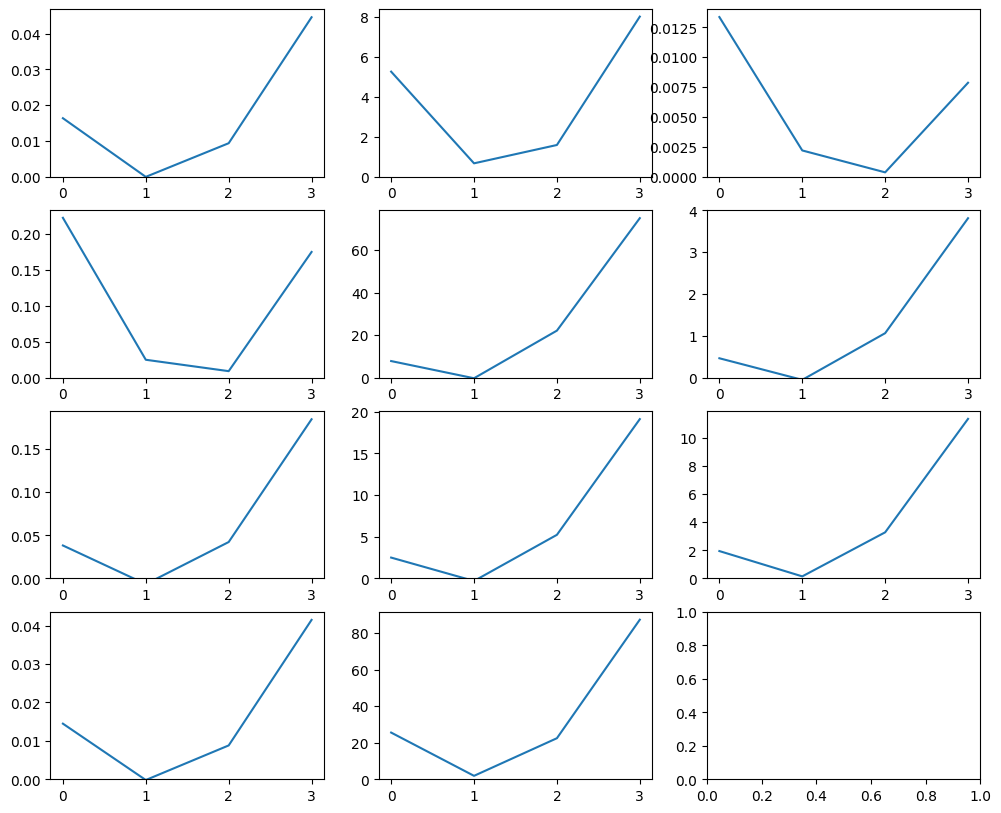

In [193]:
from scipy.interpolate import CubicSpline

def calculate_nutrient_uptake_rate(x_interp, Y_interp, num_interp_points=500):

    # Initialize an array to store the derivatives
    Y_derivative_spline = np.zeros((num_interp_points, data.shape[1]))

    # Compute the cubic spline and its derivative for each column
    for col in range(data.shape[1]):
        cs = CubicSpline(x_interp, Y_interp[:, col])  # Cubic Spline interpolation
        Y_derivative_spline[:, col] = cs.derivative()(x_interp)  # Evaluate the derivative

    plant_uptake_rate = - Y_derivative_spline 
    return x_interp, plant_uptake_rate

x_interp, plant_uptake_rate = calculate_nutrient_uptake_rate(x_interp, Y_interp, num_interp_points=4)

plot_curves(x=x_interp, y=plant_uptake_rate)

In [194]:
# def absolute_plant_uptake_from_rate(x_interp, plant_uptake_rate, start, end):
#     start_index = np.argmin(np.abs(x_interp - start)) # find the best index
#     end_index = np.argmin(np.abs(x_interp - end))
#     return np.sum(plant_uptake_rate[start_index:end_index,:],axis=0)/(end_index-start_index)

# absolute_uptake = absolute_plant_uptake_from_rate(x_interp, plant_uptake_rate, 0,1)
# print(f"{absolute_uptake = }")

In [201]:
def absolute_plant_uptake_during_interval(x_interp, Y_interp, start, end):
    start_index = np.argmin(np.abs(x_interp - start)) # find the best index
    end_index = np.argmin(np.abs(x_interp - end))
    # uptake is the negative of nutrient change in solution
    return -(Y_interp[end_index,:] - Y_interp[start_index,:]) 

target = absolute_plant_uptake_during_interval(x_interp, Y_interp, 2,3)
print(f"{target = }")

target = array([2.48333333e-02, 4.33333333e+00, 3.33333333e-03, 7.66666667e-02,
       4.60166667e+01, 2.30000000e+00, 1.05666667e-01, 1.14833333e+01,
       6.90000000e+00, 2.31666667e-02, 5.12672852e+01])


## Optimize

Consider a single time intervall $I = [t_0, T]$.

Unsing the model of the plant uptake we have obtained the the target nutrient concentration should be idealy $\vec T$.

Let us optimize the minimal total amount of fertilizer to reach the target under the constraint that the plant does not experience any deficite of nutrients.

$L = \min(|\vec{T} - (u_1 \vec{F}_1 + u_2 \vec{F}_2 + u_3 \vec{F}_3|)$

Constrain: $\vec{T} - (u_1 \vec{F}_1 + u_2 \vec{F}_2 + u_3 \vec{F}_3) \ge 0$

**Comments:**

1. Since the concentration have different scales, it might be reasonable to scale (transfrom) them using sklearn MaxMinScaler or StandartScaler.
Afterwards don't forget to apply the inverse transform to get correct values!

In [202]:
def nutrients(params, c_fertilizer1, c_fertilizer2, c_fertilizer3, c_target):
    a, b, c = params
    value = c_target - a*c_fertilizer1 - b*c_fertilizer2 - c*c_fertilizer3
    return value  

def objective_function(params, c_fertilizer1, c_fertilizer2, c_fertilizer3, c_target):
    a, b, c = params
    value = np.sum(np.abs(c_target - a*c_fertilizer1 - b*c_fertilizer2 - c*c_fertilizer3))
    return value  

def constraint_function(params, c_fertilizer1, c_fertilizer2, c_fertilizer3, c_target):
    a, b, c = params
    return np.min(c_target - a*c_fertilizer1 - b*c_fertilizer2 - c*c_fertilizer3)

def optimize(c_fertilizer1, c_fertilizer2, c_fertilizer3, c_target, constraint):
    # Initial guess for a and b
    initial_guess = [0, 0, 0]
    bounds = [(0, None), (0, None), (0, None)]  # (lower bound, upper bound) for a, b and c
    
    # Call the optimizer
    result = minimize(objective_function, initial_guess, 
                      args=(c_fertilizer1, c_fertilizer2, c_fertilizer3, c_target),
                      bounds = bounds,  # (lower bound, upper bound) for a and b
                      constraints=[constraint], 
                      method='SLSQP') 
    
    # Extract the optimized values of a and b
    a_opt, b_opt, c_opt = result.x
    return a_opt, b_opt, c_opt, result.fun  # Return optimized a, b, and the minimized value


In [203]:
c_target = np.abs(np.random.sample(11))*10

c_fertilizer1 = np.abs(np.random.sample(11))
c_fertilizer2 = np.abs(np.random.sample(11))
c_fertilizer3 = np.abs(np.random.sample(11))

# Define the constraint
constraint = {
    'type': 'ineq',  # 'ineq' means the constraint function must return >= 0
    'fun': constraint_function,
    'args': (c_fertilizer1, c_fertilizer2, c_fertilizer3, c_target)
}


a_opt, b_opt, c_opt, minimized_value = optimize(c_fertilizer1, c_fertilizer2, c_fertilizer3, c_target, constraint)
params_opt = (a_opt, b_opt, c_opt)
nut = nutrients(params_opt, c_fertilizer1, c_fertilizer2, c_fertilizer3, c_target)

print("------------------------------------------------------------------------------------------")
print(f"{minimized_value = }")
print("------------------------------------------------------------------------------------------")
print(f"{[a_opt, b_opt, c_opt] = }")
print("------------------------------------------------------------------------------------------")
print(f"Nutrient excess:")
print(f"{nut.round(3) = }")

------------------------------------------------------------------------------------------
minimized_value = 36.49731696859001
------------------------------------------------------------------------------------------
[a_opt, b_opt, c_opt] = [0.08975588225496903, 0.5561649424268956, 4.0723096230011196e-13]
------------------------------------------------------------------------------------------
Nutrient excess:
nut.round(3) = array([ 2.112,  3.187,  3.07 ,  3.727,  6.25 ,  4.477,  3.355, -0.   ,
        2.36 ,  0.   ,  7.96 ])


## Iterative process

The next step is to calculate a schedule how to fertilize the plants.
As input we give the time intervall that we want to attent to the plants.
As a ouput we want the amount of each fertilizer we have to add for each time.

Comments:
- additional statistic would be nice
- some plots would be also nice

In [3]:
def calculate_fertilization_schedule(data, time_intervall_days, c_fertilizer1, c_fertilizer2, c_fertilizer3):
    # interpolate the data 
    x_interp, Y_interp = interpolate_data(data, num_points=4*7, kind='linear')
    # calculate the uptake of each nutrient of the plant
    # x_interp, plant_uptake_rate = calculate_nutrient_uptake_rate(x_interp, Y_interp, num_interp_points=500)
    # calculate 
    time_intervall_week = time_intervall_days/7
    num_fertilization_events = int(x_interp[-1] // time_intervall_week)

    residual = 0
    results = dict()

    # build schedule
    for i in range(num_fertilization_events):
        
        start = i*time_intervall_week
        end = (i+1)*time_intervall_week

        c_target_without_residuals = absolute_plant_uptake_during_interval(x_interp=x_interp, Y_interp=Y_interp, start=start ,end=end)

        # calculate the target considering residual (excess) nutrients in the solution
        c_target = c_target_without_residuals + residual 

        # Define the constraint
        constraint = {
            'type': 'ineq',  # 'ineq' means the constraint function must return >= 0
            'fun': constraint_function,
            'args': (c_fertilizer1, c_fertilizer2, c_fertilizer3, c_target)
        }

        # optimize 
        a_opt, b_opt, c_opt, minimized_value = optimize(c_fertilizer1, c_fertilizer2, c_fertilizer3, c_target, constraint)
        
        params_opt = (a_opt, b_opt, c_opt)
        
        # calculate the excess nutrient after time period
        residual = nutrients(params_opt, c_fertilizer1, c_fertilizer2, c_fertilizer3, c_target)

        # store the results
        results[f"day_{int(start*7)}"] = {'f1' : a_opt,
                                     'f2' : b_opt,
                                     'f3' : c_opt,
                                     'excess' : residual.round(3),
                                     'objective_function': minimized_value}
        
    return results

c_fertilizer1 = np.abs(np.random.sample(11))*0.01
c_fertilizer2 = np.abs(np.random.sample(11))*0.01
c_fertilizer3 = np.abs(np.random.sample(11))*0.01
   
results = calculate_fertilization_schedule(data=data, time_intervall_days=1, c_fertilizer1=c_fertilizer1, c_fertilizer2=c_fertilizer2, c_fertilizer3=c_fertilizer3)

results

NameError: name 'data' is not defined

In [199]:
3*7

21